In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import stats
import math
import h5py
import os.path

In [2]:
def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

def lineseg_dist(p, a, b): 
    n_p = p.shape[0] 
    n_s = a.shape[0]

    p_s = np.tile(p, (n_s,1))
    a_s = np.tile(a, (1,n_p)).reshape((-1,2))
    b_s = np.tile(b, (1,n_p)).reshape((-1,2))
    
    dists = lineseg_dists(p_s, a_s, b_s)
    dists = dists.reshape((-1, n_p)).reshape((-1, n_p))
    dists = np.min(dists, axis=0)
    
    return dists


# p = np.array([[0,1],[0,2],[0,3],[0,4]])
# a = np.array([[1,1],[2,2],[3,3]])
# b = np.array([[2,2],[3,3],[4,4]])

# n_p = p.shape[0] 
# n_s = a.shape[0]

# p_s = np.tile(p, (n_s,1))
# a_s = np.tile(a, (1,n_p)).reshape((-1,2))
# b_s = np.tile(b, (1,n_p)).reshape((-1,2))

# dists = lineseg_dist(p, a, b)

In [3]:
pref_folder = "/groups/esm/dzhuang/Catheter/"
train_data_folder = "/home/tingtaoz/storage/traindatalevy"

# Preprocess bacteria data tune parameters

(0.0, 40.464367681717334)

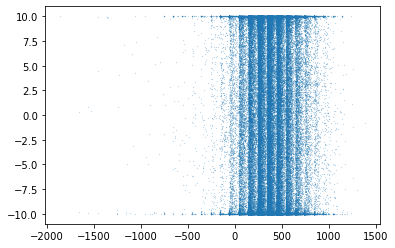

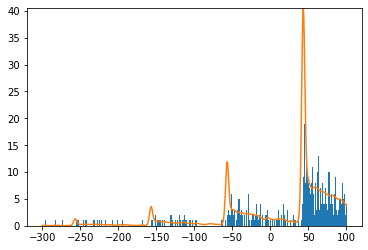

In [16]:
# Study the effect of bw_method
bw_method = 1e-2

n_periods = 4
n_particle = 100000
dx = 0.1
nc = 1000
nbins = n_periods*nc + 1
dx = 100/nc
myrange = (-100*(n_periods - 1)-dx/2, 100+dx/2)
xx = np.linspace(-100*(n_periods - 1),100, nbins)

# user chooses t and x2 x3 h
# check t is consistent with data
t = 99
x2, x3, h = 43, 43, 2

file_names = glob.glob(train_data_folder+"/*"+str(x2)+"_"+str(x3)+"_"+str(h)+".h5")
assert( len(file_names) == 1 and os.path.exists(file_names[0]) )

hf = h5py.File(file_names[0], "r")
x_b = hf["config"][str(t+1)]["x"][:]
y_b = hf["config"][str(t+1)]["y"][:]
plt.figure()
plt.scatter(x_b +99, y_b, s=0.01)
    
    
bacteria_1d_data = x_b + 99

bacteria_bin = np.histogram(bacteria_1d_data, bins=nbins, range=myrange)[0]
kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
density_1d_data = kernel(xx)*n_particle*dx

# density 
plt.figure()
plt.hist(bacteria_1d_data, bins=nbins, range=myrange)
plt.plot(xx,  density_1d_data)
plt.ylim([0, max(density_1d_data)])

In [18]:
n_data = len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5))

    
    
bacteria_1d_data = np.zeros((n_particle, n_data))
density_1d_data = np.zeros((nbins, n_data))
density_1d_raw_data = np.zeros((nbins, n_data))
# change t
t = 99
# change bw_method for scipy.stats.gaussian_kde
bw_method = 5e-2


idx = 0
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
            if h.is_integer():
                h = np.int64(h)
            file_names = glob.glob(train_data_folder+"/*"+str(x2)+"_"+str(x3)+"_"+str(h)+".h5")
            if len(file_names) == 1 and os.path.exists(file_names[0]):
                hf = h5py.File(file_names[0], "r")
                
                x_b = hf["config"][str(t+1)]["x"][:]
                bacteria_1d_data[:,  idx] = x_b + 99
                
                bacteria_bin = np.histogram(bacteria_1d_data[:,  idx], bins=nbins, range=myrange)[0]
                density_1d_raw_data[:, idx] =  bacteria_bin
                kernel = stats.gaussian_kde(bacteria_1d_data[:,  idx], bw_method = bw_method)
                density_1d_data[:, idx] = kernel(xx)*n_particle*dx
            else:
                print("warning: cannot find " + "*_" + str(x2) + "_" + str(x3) + "_" + str(h)+".h5")
                    
            idx += 1

np.save(pref_folder+"bacteria_1d_data.npy", bacteria_1d_data)
np.save(pref_folder+"density_1d_data.npy", density_1d_data)
np.save(pref_folder+"density_1d_raw_data.npy", density_1d_raw_data)